<a href="https://colab.research.google.com/github/TariqMBrown/CIVICs/blob/main/Annotated_CIViCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **READ ME!**

Hello user. This is a code made by Tariq Brown specifically for processing 2-Photon calcium imaging data, but should work for any 2-dimensional (x,y) time series data.

This is the fully annotated version of civics, so it is a little more cluttered, but should explain every step. The red text will explain all the aspects of the code. Green text that has a # before it will also help explain some aspects.

Certain aspects are grouped together (it will have a title, and under that title it will have x number of hidden cells, you can run them all together by pressing the play button while the cells are hidden).

Use # at the beginning of a line to "comment" it out. When you run the cell, that line will be ignored.


If you have any issues, please email Tariq at Tariq_Brown@brown.edu or TariqMBrown@gmail.com

Currently working on:

Specifying where the cells are/ which cells flies they came from

Fix heatmaps window, color and scale, make for black background, text size

Automatically inserting P values on graphs




# Imports and Definitions

In [ ]:
"""
If you plan on working within google drive, ensure that you mount your drive so you can access your files.
after your drive is mounted, you should be able to access your drive files by clicking on the folder
icon to the left, and navigating to your working path.  "drive" -> "MyDrive" -> File Location
"""
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
These are things not native to the known libraries within colab, so we have to you pip and apt to modify
the current colab space. make sure you load these in everytime.
"""
%pip install scikit-posthocs
%pip install scikit-learn matplotlib
!apt-get install -y imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
imagemagick is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
"""
These are imports necessary for the codes function. Make sure you run these everytime.
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import collections
import csv
import time
from collections import Counter
import os.path
from os import path
import math
from statistics import mode
from numpy import ones,vstack
from numpy.linalg import lstsq
import matplotlib as pltc
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog
from IPython.display import display, clear_output
import time
from PIL import Image, ImageDraw
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, levene, f_oneway, kruskal
import scikit_posthocs as sp
from scipy.stats import f_oneway
from scipy.integrate import trapz
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.vq import vq, kmeans2
import matplotlib.patches as patches
from random import seed
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

Secs_in_Min = 60
FPS = 31

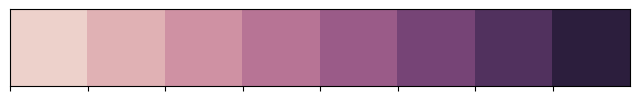

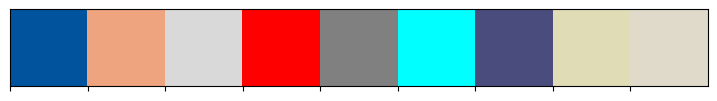

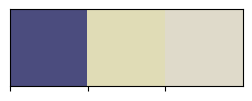

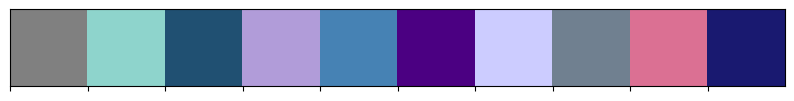

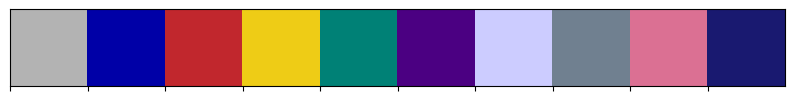

In [ ]:
# @title Color Selection
"""
This is where you can select your preferred colors. Either use matploblib friendly color words, which are listed
here: https://matplotlib.org/stable/gallery/color/named_colors.html

or use hexidecimal codes.

You can find palette creators here: https://coolors.co/d7fff1-aafcb8-8cd790-77af9c-285943
and here: http://colormind.io/
"""

colors = ['#00539C', '#EEA47F', '#D9D9D9', 'red', 'gray', 'cyan', '#4b4c7e', '#e0dcb6', '#dfdaca']
colors2 = ['#4b4c7e', '#e0dcb6', '#dfdaca']
palette2 = ["#808080","#8ed4cc","#205072","#b19cd9","#4682b4","#4b0082","#CCCCFF","#708090","#DB7093","#191970"]
custom_palette = ["#b3b3b3","#0000a7","#c1272d","#eecc16","#008176","#4b0082","#CCCCFF","#708090","#DB7093","#191970"]

sns.palplot(sns.cubehelix_palette(8))
sns.palplot(colors)
sns.palplot(colors2)
sns.palplot(palette2)
sns.palplot(custom_palette)


custom_palette = ["#b3b3b3","#0000a7","#c1272d","#eecc16","#008176","#4b0082","#CCCCFF","#708090","#DB7093","#191970"]


In [ ]:
"""
"""
filepath = '/content/drive/MyDrive/Brown University/Kaun Lab/2-photon Kaun/CIVICs/Output' # change the path to where you want the files to be saved
filename = 'Place Holder'
project = 'Place Holder'
date = 'Place Holder'
window_start = 0 # can chnage this to shift your window of interest (start point in frames)
window_end = 1426  # can change this to shift your window of interst (end point in frames) 810/806 for my 13 mins videos, 1426 for the 23 min ones
stimulus_start = 124 #*62
stimulus_end = 744 #744 for 12 min mark
stimulus2_start = 744
stimulus2_end = 1364 #for acq, 1364
baseline_start_1 = stimulus_start - 10
baseline_end_1 = stimulus_start - 1
baseline_start_2 = stimulus2_start - 10
baseline_end_2 = stimulus2_start - 1
ybottom = None #if you wanna change the y limit minimum
ytop = None #if you wanna change the maximum y limit dispayed
Region = 'Insert Region Here' #this can be changed to 'Soma','Axon', 'Dendrite', or 'Other'

time_for_bins = 10 #5 second bins default
bin_size = math.ceil((window_end - window_start)/time_for_bins)
stimulus_name = 'Unpaired'
stimulus2_name = 'Paired'

spike_threshold = 0.5
p_threshold = 0.05
Single_Stim = False
Acquisition = True
Retrieval = False

In [ ]:
"""
These are the functions necessary for multiple parts of this code. They will have a comment above them describing their functions
"""

"""
column namer - function that iterates through a provided csv and gives it column names in the order of; Soma, Axon, Dendrite, other. So order your csvs accordingly
for example, columns 0-3 are all soma, columns 4-5 are axons, and columns 7-9 are dendrites
df = pandas dataframe (this will be the column nameless csv that you load in)
soma_num = float indicating the number of soma
axon_num = float indicating the number of axon
dendrite_num = float indicating the number of dendrite
other_num = float indicating the number of other structures

"""
def column_namer (df, soma_num=None, axon_num=None, dendrite_num=None, other_num=None):
    soma_counter = 1
    axon_counter = 1
    dendrite_counter = 1
    other_counter = 1
    column_names = [] #need to initalize with the name 'Frame', as to not cause mismatch error
    if soma_num > 0:
        for i in range(soma_num):
            column_names.append("Soma" + ' ' + str(soma_counter))
            soma_counter +=1
    if axon_num > 0 :
        for i in range(axon_num):
            column_names.append("Axon" + ' ' + str(axon_counter))
            axon_counter +=1
    if dendrite_num > 0 :
        for i in range(dendrite_num):
            column_names.append("Dendrite" + ' ' + str(dendrite_counter))
            dendrite_counter +=1
    if other_num > 0 :
        for i in range(soma_num):
            column_names.append("Other" + ' ' + str(other_counter))
            other_counter +=1
    column_names.insert(0, 'Frame')
    df.columns = [column_names]
    return df

"""
this is the baselining method used for the code.
Use the first baseline_align def for acquisition and just EtOH exposure
use the second one for retireval experiments
df = pandas dataframe (the csv of your data)
time 1 (float) = Number representing the start of your desired baseline period
time 2 (float) = Number representing the end of your desired baseline period
time 3 (float) = Number representing the start of your second desired baseline period
time 4 (float) = Number representing the end of your second desired baseline period
"""
def Baseline_Align_1(df, time1 = baseline_start_1, time2 = baseline_end_1):
    baseline_frame = df.iloc[time1:time2]
    mean = baseline_frame.mean()
    df =(df - mean)/mean
    return df

# Example usage:
# df is your original DataFrame with a DateTime index
# start_date and end_date define the time period for calculating the mean
# normalized_df = normalize_dataframe_to_mean(df, '2023-01-01', '2023-12-31')
def Baseline_Align_2(df, time1 = baseline_start_1, time2 = baseline_end_1, time3 = baseline_start_2, time4 = baseline_end_2,
                   time5 = stimulus_start, time6 = stimulus_end, time7 = stimulus2_start, time8 = stimulus2_end):

    baseline_frame = df.iloc[time1:time2]
    if time3 and time4 > 0:
      baseline_frame2 = df.iloc[time3:time4]
      mean2 = baseline_frame2.mean()
    mean = baseline_frame.mean()
    df.iloc[window_start:time6+15] =(df.iloc[window_start:time6+15] - mean)/mean #+14?
    if time3 and time4 >0 :
      df.iloc[time7-15:window_end] =(df.iloc[time7-15:window_end] - mean2)/mean2 #
    return df
"""
 This will utlize the baseline_align function to baseline the dataframe, it iterates through each column and baselines
 df (pandas DataFrame) = csv of your data
"""
def Baseline(df):
    #print(df)
    new_columns = []
    for columns in df:
        e = (str(columns))
        if Acquisition == 1 or Single_Stimulus == 1:
          a = pd.DataFrame({e +' DF/F':Baseline_Align_1(df[columns])})
        elif Retrieval == 1:
          a = pd.DataFrame({e +' DF/F':Baseline_Align_2(df[columns])})
        else:
          raise ValueError('Please ensure that you have set either Acquisition or Retrieval to True so that the code can baseline properly :)!')
        df = pd.concat([df, a], axis = 1)
    for columns in df:
        new_columns.append(str(columns).replace("(","").replace(")","").replace(",","").replace("'",""))
    df.columns = new_columns
    df = df.drop(columns = 'Frame DF/F', axis = 1)
    #print(df)
    return df
"""
All of the following are very poor pieces of code. I am sorry. But it does the job.
Region_Avg and Region_SEM returns the mean and average for the region within your dataframe
"""
def Soma_Avg(df):
    df = df.filter(regex = 'Soma')
    mean = df.mean(axis = 1)
    return mean
def Soma_SEM(df):
    df = df.filter(regex = 'Soma')
    standard_error = df.sem(axis = 1)
    return standard_error
def Axon_Avg(df):
    df = df.filter(regex = 'Axon')
    mean = df.mean(axis = 1)
    standard_error = df.sem(axis = 1)
    return mean
def Axon_SEM(df):
    df = df.filter(regex = 'Axon')
    standard_error = df.sem(axis = 1)
    return standard_error
def Dendrite_Avg(df):
    df = df.filter(regex = 'Dendrite')
    mean = df.mean(axis = 1)
    standard_error = df.sem(axis = 1)
    return mean
def Dendrite_SEM(df):
    df = df.filter(regex = 'Dendrite')
    standard_error = df.sem(axis = 1)
    return standard_error
def Other_Avg(df):
    df = df.filter(regex = 'Other')
    mean = df.mean(axis = 1)
    standard_error = df.sem(axis = 1)
    return mean
def Other_SEM(df):
    df = df.filter(regex = 'Other')
    standard_error = df.sem(axis = 1)
    return standard_error
"""
df (pandas DataFrame) = the dataframe that has been baselined will be fed into this function

takes the mean and sem of each of the regions
"""
def Mean_and_SEM(df):
    SomaAvg = Soma_Avg(df)
    AxonAvg = Axon_Avg(df)
    DendriteAvg = Dendrite_Avg(df)
    OtherAvg = Other_Avg(df)
    SomaSEM = Soma_SEM(df)
    AxonSEM = Axon_SEM(df)
    DendriteSEM = Dendrite_SEM(df)
    OtherSEM = Other_SEM(df)
    MeanSEMdf = pd.DataFrame({"Frame": range(1, 1 +len(df)), "Soma Average": SomaAvg,"Axon Average": AxonAvg,
                  "Dendrite Average": DendriteAvg,"Other Average": OtherAvg, "Soma SEM": SomaSEM,
                           "Axon SEM": AxonSEM, "Dendrite SEM": DendriteSEM, "Other SEM": OtherSEM }) #for some reason couldnt get the frames to carry over from previous dataframe
    return MeanSEMdf
"""
unused function. But if you want rasters of your data, you can use this function. Very similar to heatmap
df (pandas DataFrame) = baseline_aligned dataframe of your data
"""
def rasterize (df):
  tempdf = df
  # Find the index when each column reaches its maximum value
  max_indices = tempdf.idxmax()
  sorted_columns = df[max_indices.sort_values().index]
  print(sorted_columns)
  for column in df.columns:
    tempdf[column]
    for index, row in tempdf[column].iteritems():
      if row < spike_threshold:
        tempdf[column] = tempdf[column].replace(row, 0)
      else:
        tempdf[column] = tempdf[column].replace(row, 1)

  positions = tempdf.apply(lambda x: tempdf.index[x == 1])
  #print(positions)

  # Create raster plot with inverted y-axis to display columns in ascending order
  #print(tempdf.index)
  plt.eventplot(positions, linelengths=0.75, colors='black')
  plt.yticks(range(positions.index.size), positions.index)
  plt.gca().invert_yaxis()
  return tempdf
"""
plotme - function that graphs the entire dataframe provided by default. Can be used to

df = pandas dataframe containing baseline aligned fluorescent values produced by the baseline_align function can also be used after its been meaned by mean_and_sem function
time1 - time 6 = floats representing time points in seconds
ybottom = float representing the min for the y-axis
ytop = float representing the max for the y-axis
stimname = string representing the name of the stimulation provided
color_num = index of the color you want to select based on the colors array at the beginning of the code
"""
def plotme(df, filepath, filename, region,
          time1, time2, time3=None, time4=None, time5=None, time6=None,
          ybottom=None, ytop=None, stimname=None, stim2name=None, color_num = None):
    window_of_interest = df.iloc[time1:time2]
    roi = region
    if region == 'Axon':
        n = str(axon_num)
    elif region == 'Soma':
        n = str(soma_num)
    elif region == 'Dendrite':
        n = str(dendrite_num)
    elif region == 'Other':
        n = str(other_num)
    tempdf = pd.DataFrame({'Frame':df['Frame'], roi + ' Average': df[roi +' Average']})
    new_time_bins = pd.cut(df['Frame'], bin_size)
    df['New_Time_Bins'] = new_time_bins
    #print(df)
    df['Factors'], bins = pd.factorize(df['New_Time_Bins'], sort = True)
    g = sns.lineplot(data = df, x = 'Factors', y =  roi + ' Average', errorbar = None,
                     color = custom_palette[color_num])
    g.set(xlabel = 'Time (secs)', #xlabel = 'Time binned by ' + str(time_for_bins) + ' seconds',
          ylabel = 'DF/F',
          xlim = (df['Factors'].min(), df['Factors'].max())
    )
    g.legend()

    df = df.groupby('Factors').mean()
    error = df[roi + ' SEM']
    y = df[roi + ' Average']
    g.fill_between(df.index, y-error, y+error, color = custom_palette[color_num], alpha = 0.2)


    # x = tempdf['Frame'].values
    # y = tempdf[roi+' Average']
    # error = df[roi + ' SEM']
    # plt.axvspan(time3, time4, facecolor='gray', alpha=0.2)
    # plt.axvspan(time5, time6, facecolor='red', alpha=0.2)
    # plt.fill_between(x, y-error, y+error, color = 'purple', alpha = 0.2)
    # plt.xlim(time1, time2)
    # plt.ylim(ybottom, ytop)
    # plt.plot(x, y, 'purple')
    # plt.plot([window_start,window_end],[0,0], 'k--') # add black line at 0
    plt.title(filename+ ' (n = ' + n + ')')
    # plt.xlabel('Time (secs)', color='#1C2833')
    # plt.ylabel('DF/F', color='#1C2833')
    plt.savefig(filepath + '/' + project + '/' + date + '/' +filename + ' graph.pdf')
    return filename+'saved to '+ filepath +' !'


def heatmap(df, filename, filepath, windowed = [0,0], time1 = None, time2 = None, time3 = None, cmap = None):
  """
  df = pandas dataframe containing the baseline_aligned columns BEFORE they have been averaged by mean_sem function
  filename = (string) what would you like your filename to be
  filepath (string) string contsaining the location you would like the heatmap pdf saved to
  time = (float)
  windowed: (bool) if set true, will sort the columns even further based on when the maximum value is (if it occurs in time 1 to midpoint between time 1 and time 2, midpoint time 1/2
  to time 2, time 2 to midpoint time 2 to 3, midpoint time 2 to 3 to want to incorporate a function that breaks down the heatmap even further, classifying neurons that reach their max intensity
  within the first portion of sitmulus 1, second portion of simulus 1, first portion of stimulus 2, and
  """
  tempdf = df
  columns = tempdf.columns
  x = tempdf.values
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit_transform(x)
  tempdf = pd.DataFrame(scaler)
  if windowed[0] == 0:
    # Find the index when each column reaches its maximum value
    max_indices = tempdf.idxmax()
    sorted_columns = tempdf[max_indices.sort_values(ascending = True).index]
    sns.heatmap(sorted_columns.T, cmap = cmap)
  #if you want to look at early and late for one stimulus
  if windowed[0] == 1 and windowed[1] == 0:
    #find position at which the max value occurs
    max_indices = tempdf.idxmax()
    # Categorize columns into two groups based on index value
    early_group = [col for col, idx in max_indices.items() if idx <= ((time1+time2)/2)]
    late_group = [col for col, idx in max_indices.items() if ((time1+time2)/2) <= idx]
    # Sort columns within each group

    early_group_sorted = df[early_group].sort_index(axis=1)
    early_group_sorted.reset_index

    late_group_sorted = df[late_group].sort_index(axis=1)
    late_group_sorted.reset_index

    sorted_df = pd.concat([early_group_sorted, late_group_sorted])
    sns.heatmap(early_group_sorted.T, cmap = cmap)
    sns.heatmap(late_group_sorted.T, cmap = cmap)

  # [1,1] for acquisition
  if windowed[0] == 1 and windowed[1] == 1:
    max_indices = tempdf.idxmax()
    early1 = [col for col, idx in max_indices.items() if idx <= ((time1+time2)/2)]
    late1 = [col for col, idx in max_indices.items() if ((time1+time2)/2)< idx < time2]
    early2 = [col for col, idx in max_indices.items() if time2 < idx < ((time2+time3)/2)]
    late2 = [col for col, idx in max_indices.items() if ((time2+time3)/2) <= idx]

    early1_group_sorted = df[early1].sort_index(axis=1)
    late1_group_sorted = df[late1].sort_index(axis=1)
    early2_group_sorted = df[early2].sort_index(axis=1)
    late2_group_sorted = df[late2].sort_index(axis=1)
    # Concatenate the sorted groups back into a single DataFrame
    sorted_df = pd.concat([early1_group_sorted, late1_group_sorted, early2_group_sorted, late2_group_sorted])
    #sorted_df = sorted_df.reset_index
    sns.heatmap(sorted_df.T, cmap = cmap)
    #plt.labels = [heatlabels]

  plt.axvline(time1, color = 'k')
  plt.axvline(time2, color = 'k')
  if time3 != None:
    plt.axvline(time3, color = 'k')
  plt.title(filename)
  plt.savefig(filepath + '/' + project + '/' + date + '/' +filename + ' Heatmap.pdf')

"""
mean_at_time does exactly what it says. Takes the mean given the provided time points

df (pandas DataFrame) = baselined dataframe
"""

def mean_at_time(df, time1, time2):
  df = df.iloc[time1:time2]
  mean = df.mean(axis = 0)
  return mean

"""
function that takes a given p value and converts it to significance asterisks. To be used when generating plots.
pvalue (float) = value associated with the outcome of a statistical test.
"""

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"
"""
function that normalizes data
f (numpy array) = array containing baselined/meaned fluorescent values
"""
def norm(f):
    return (f - np.min(f))/np.max(f - np.min(f))

# Loading in Data and Formatting

In [ ]:
#Load in your file
f = pd.read_csv('Your Filepath Here', header = None) #insert path here
#f2 = pd.read_csv('', header = None) # can add more files by inserting there paths here, and adding f2,f3... to the raw_df generation
project = 'Test' # name of the project this work belongs to
date = '2023-12-04' #YYYY-MM-DD
filename = 'Test' # Insert Filename here
# try making the directory for the project and data of the data
try:
   os.makedirs(os.path.join(filepath, project, date))
except FileExistsError:
   # directory already exists
   pass
#creates a new dataframe that will be apended to your csv that represents frame of each value
frame = pd.DataFrame(range(1, 1+ len(f)))
# makes the raw_df of the raw fluorescence values and frames
raw_df = pd.concat([frame, f], axis =1)
# determine what paradigm you are using, set one of the following three to 'True' and the others to 'False' to select one
Single_Stimulus = True
Acquisition = False
Retrieval = False
# Name of Stimulus
Stimulus_Name = 'Ethanol'
stimulus_name = 'Unpaired'
stimulus2_name = 'Paired'


# LET US FIRST DEFINE SOME PARAMETERS
window_start = 0
window_end = 806
stimulus_start = 124
stimulus_end = 744
stimulus2_start = 0
stimulus2_end = 0
early_stim_end = stimulus_start + 62
late_stim_start = stimulus_start - 62
early_stim2_end = stimulus2_start + 62
late_stim2_start = stimulus2_end - 62

#how many you got of the following?
# make sure the data is oriented [Soma, Axon, Dendrite, Other] or if you are just using one type, ignore orientation
#ensure that the number of columns you feed into the code equals the total number of columns you want labeled
soma_num = 0
axon_num = 42
dendrite_num = 0
other_num = 0
#determines where baseline(s) start and ends
baseline_start_1 = stimulus_start - 11
baseline_end_1 = stimulus_start - 1
baseline_start_2 = stimulus2_start - 11
baseline_end_2 = stimulus2_start - 1
#determines stimuli durations, starts, and ends
stimulus_duration = [stimulus_start,stimulus_end]
stimulus2_duration = [stimulus2_start,stimulus2_end]
early_stimulus_duration = [stimulus_start,((stimulus_start+stimulus_end)/2)]
late_stimulus_duation = [((stimulus_start+stimulus_end)/2),stimulus_end]
early_stimulus2_duration = [stimulus2_start,((stimulus2_start+stimulus2_end)/2)]
late_stimulus2_duation = [((stimulus2_start+stimulus2_end)/2),stimulus2_end]
total_duration = 806

#determine how you want your data binned
time_for_bins = 10 #5 second bins default
bin_size = math.ceil((window_end - window_start)/time_for_bins)



spike_threshold = 0.5 # necessary for ununused rasterize function

Region = 'Axon' #axon/soma/dendrite/other
df = raw_df.iloc[0:window_end] #248 or 806 or 1426 == this is your window that will be graphed
df = column_namer(df, soma_num, axon_num, dendrite_num, other_num)
df = Baseline(df)
df = df.filter(like='DF/F')


"""
Specify which indicies are for which groups within your dataframe (based on columns)
"""
"If you have any flies that are not responding, or if you want to isolate the ones that are specific to a stimulus drop them from the dataframe"
drop = [] # non responsder
df = df.drop(df.columns[drop], axis =1)

#if you want labels (optional) for each individual column, insert the proper amount here, and you can choose to use them later
mylabels = []

# Visualization 1: Time Series Graphs

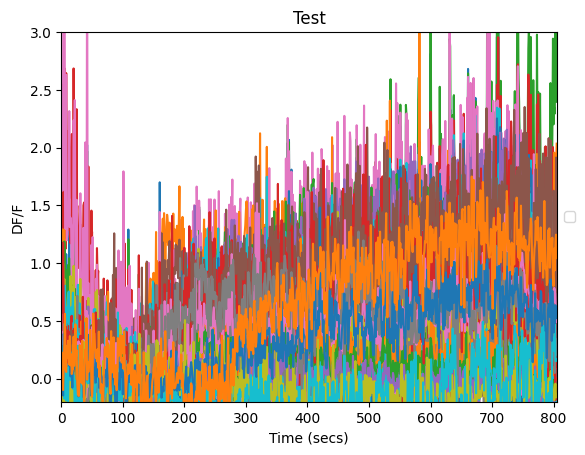

In [ ]:
"""
Plotting each individual trace without the mean
"""

df.plot()
plt.xlim(0, window_end)
plt.ylim(-0.2, 3.0)
plt.xlabel('Time (secs)')
plt.ylabel('DF/F')
plt.title(filename)
#change color_background to True if you want to change the background color to highlight when a stimulus is present
color_background = False
if color_background == True:
  plt.fill_between([stimulus_start, stimulus_end], -0.4, 0.6, color = custom_palette[1], alpha = 0.3)
  plt.fill_between([stimulus2_start, stimulus2_end], -0.4, 0.6, color = custom_palette[3], alpha = 0.3)
plt.legend(loc='center left', labels = mylabels, bbox_to_anchor=(1, 0.5))
plt.savefig(filepath + '/' + project + '/' + date + '/' +filename + ' Individual Traces'+ ' graph.pdf')

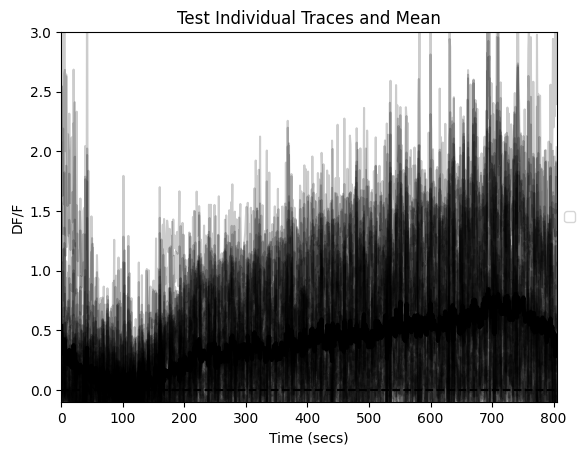

In [ ]:
"""
Plotting each individual trace WITH the mean
"""
df.plot(color = 'k', alpha = 0.2)
mean = df.mean(axis = 1)
plt.plot(mean, 'k', linewidth = 3)
plt.xlim(0, window_end)
plt.ylim(-0.1, 3.0)
plt.plot([window_start,window_end],[0,0], 'k--') # add black, dashed line at 0
plt.xlabel('Time (secs)')
plt.ylabel('DF/F')
#change color_background to True if you want to change the background color to highlight when a stimulus is present
color_background = False
if color_background == True:
  plt.fill_between([stimulus_start, stimulus_end], -0.4, 0.6, color = custom_palette[1], alpha = 0.3)
  plt.fill_between([stimulus2_start, stimulus2_end], -0.4, 0.6, color = custom_palette[3], alpha = 0.3)
plt.title( filename + ' Individual Traces and Mean')
plt.legend(loc='center left', labels = mylabels[0:(len(df))], bbox_to_anchor=(1, 0.5))
plt.savefig(filepath + '/' + project + '/' + date + '/' +filename + ' Individual Traces and Mean'+ ' graph.pdf')

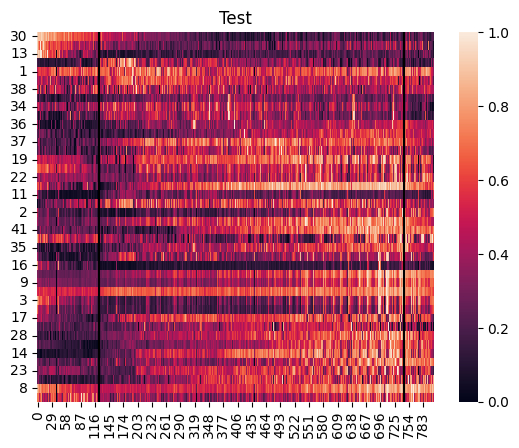

In [ ]:
"""
Heatmap function described earlier in code
windowed [0,0] for single stim, [0,1] for early and late of one stimulus, [1,1] for acquisition
times = times you want to look at
cmap can be any of the seaborn heatmaps. 'None' will set it to magma by default, but viridis, crest and others are popular
choose a cmap here: https://seaborn.pydata.org/tutorial/color_palettes.html
"""

heatmap(df, filename, filepath, windowed = [0,0],
        time1 = stimulus_start, time2 = stimulus_end, time3 = None,
        cmap = None)

In [ ]:

# Each time series plotted stacked
# """
# fig, axs = plt.subplots(2)
# ax1 = plt.subplot(1,1,1)
# ts = np.asarray(range(window_end))
# #how many cells to select
# cell_ids = range(42)
# #selects random number of cells, with no repeats
# cell_ids = np.random.choice(range(len(df)), len(df), replace=False)
# for cell_i in range(len(cell_ids)):
#     plt.subplot(1,2,2)
#     #plt.plot(ts, norm(df.iloc[cell_ids[cell_i],:]) + cell_i ,'k')
#     plt.plot(range(len(df), df['Axon ' + str(cell_i+1) + ' DF/F'] + cell_i, 'k'))
# ax1.set_yticks(range(len(cell_ids)))
# ax1.set_ylabel('Cell ID')
# ax1.set_xlabel('Time, sec')

# ax1.set_aspect(window_end / len(cell_ids))


In [ ]:
# np.random.seed(42)
# time = range(1, 1+ len(df))
# num_time_series = 42


# fig, axes = plt.subplots(nrows=num_time_series, ncols=1, figsize=(10, 2*num_time_series), sharex=True, gridspec_kw={'hspace': 0})

# for i, ax in enumerate(axes):
#     ax.plot(time, df.iloc[i, :-1], label=f'Time Series {i+1}')
#     ax.set_yticklabels([])  # Remove y-axis tick labels
#     ax.set_ylabel('')
#     ax.legend()

# # Add common x-axis label and title
# axes[-1].set_xlabel('Time')
# fig.suptitle('Line Plots for Each Row')

# # Add y-axis tick labels with time series numbers
# plt.yticks(np.arange(0.5, num_time_series + 0.5, 1), [f'Time Series {i+1}' for i in range(num_time_series)])

# plt.show()

<ipython-input-10-1b85626c1713>:215: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('Factors').mean()


'Testsaved to /content/drive/MyDrive/Brown University/Kaun Lab/2-photon Kaun/CIVICs/Output !'

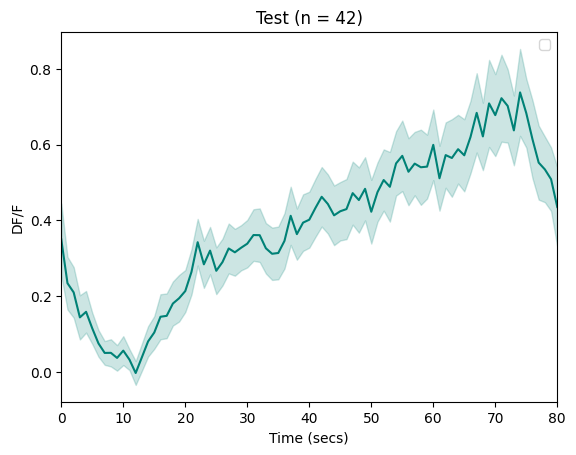

In [ ]:
#takes the mean of the baseline_aligned df and plots it
mean_df = Mean_and_SEM(df)
#plt.plot([0,80],[0,0], 'k--')
#plt.plot([stimulus_start/10,stimulus_end/10],[-0.03,-0.03], 'k-')
#plt.plot([stimulus2_start/10,stimulus2_end/10],[-0.03,-0.03], 'r--')
#plt.xlim(time1, time2)
#plt.ylim(-0.05, 1.2)
plotme(mean_df, filepath, filename, Region, window_start, window_end, stimulus_start, stimulus_end, stimulus2_start, stimulus2_end, ybottom, ytop,
        color_num = 4)

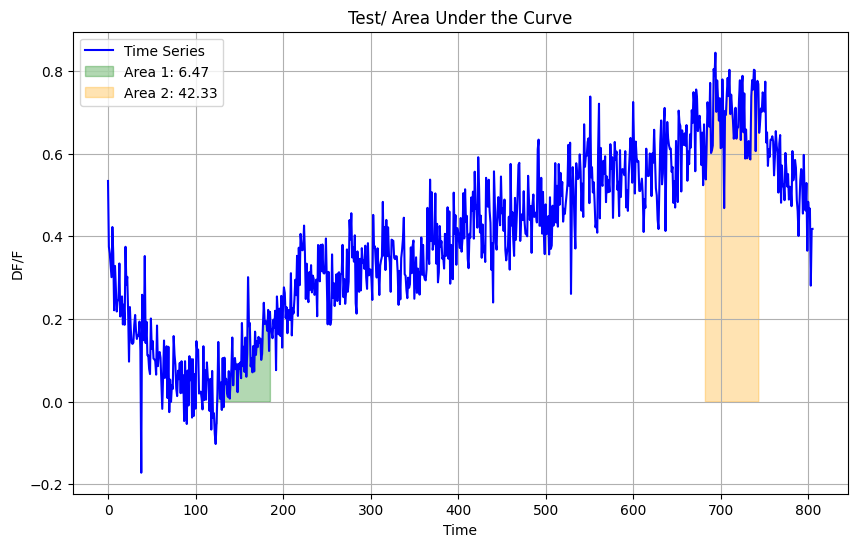

In [ ]:
"""
This box looks at Area under the curve using the trapezoidal method
"""

#print(df)
time_interval = 1  # Adjust this as needed
time_column = [i * time_interval for i in range(len(df))]

# Add the time column to the DataFrame
mean_df['Time'] = time_column
# Define the time periods you want to compare
if Single_Stimulus == 1:
  start_time_period1 = stimulus_start
  end_time_period1 = stimulus_start+62
  start_time_period2 = stimulus_end-62
  end_time_period2 = stimulus_end
if Acquisition == 1:
  start_time_period1 = stimulus_start
  end_time_period1 = stimulus_start+62
  start_time_period2 = stimulus_end-62
  end_time_period2 = stimulus_end
  start_time_period3 = stimulus2_start
  end_time_period3 = stimulus2_start+62
  start_time_period4 = stimulus2_end-62
  end_time_period4 = stimulus2_end
if Retrieval == 1:
  start_time_period1 = stimulus_start
  end_time_period1 = stimulus_end
  start_time_period2 = stimulus2_start
  end_time_period2 = stimulus2_end


# Select the data for the two time periods
period1_data = mean_df.iloc[start_time_period1:end_time_period1]
period2_data = mean_df.iloc[start_time_period2:end_time_period2]
if Acquisition == 1:
  period3_data = mean_df.iloc[start_time_period3:end_time_period3]
  period4_data = mean_df.iloc[start_time_period4:end_time_period4]

# Calculate the area under the curve for each time period
area_period1 = trapz(period1_data[Region + ' Average'], x=period1_data['Time'])
area_period2 = trapz(period2_data[Region + ' Average'], x=period2_data['Time'])
if Acquisition == 1:
  area_period3 = trapz(period3_data[Region + ' Average'], x=period3_data['Time'])
  area_period4 = trapz(period4_data[Region + ' Average'], x=period4_data['Time'])

# Create a plot and fill the areas under the curves with different colors
plt.figure(figsize=(10, 6))
plt.plot(mean_df['Time'], mean_df[Region + ' Average'], label='Time Series', color='blue')
plt.fill_between(period1_data['Time'], period1_data[Region + ' Average'], color='green', alpha=0.3, label=f'Area 1: {area_period1:.2f}')
plt.fill_between(period2_data['Time'], period2_data[Region + ' Average'], color='orange', alpha=0.3, label=f'Area 2: {area_period2:.2f}')
if Acquisition == 1:
  plt.fill_between(period3_data['Time'], period3_data[Region + ' Average'], color='green', alpha=0.3, label=f'Area 3: {area_period2:.2f}')
  plt.fill_between(period4_data['Time'], period4_data[Region + ' Average'], color='red', alpha=0.3, label=f'Area 4: {area_period2:.2f}')
plt.legend()

plt.xlabel('Time')
plt.ylabel('DF/F')
plt.title(filename + '/' +' Area Under the Curve')
plt.grid(True)
plt.savefig(filepath + '/' + project + '/' + date + '/' +filename + ' AUC graph.pdf')

plt.show()

<ipython-input-10-1b85626c1713>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['New_Time_Bins'] = new_time_bins
<ipython-input-10-1b85626c1713>:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Factors'], bins = pd.factorize(df['New_Time_Bins'], sort = True)
<ipython-input-10-1b85626c1713>:215: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which s

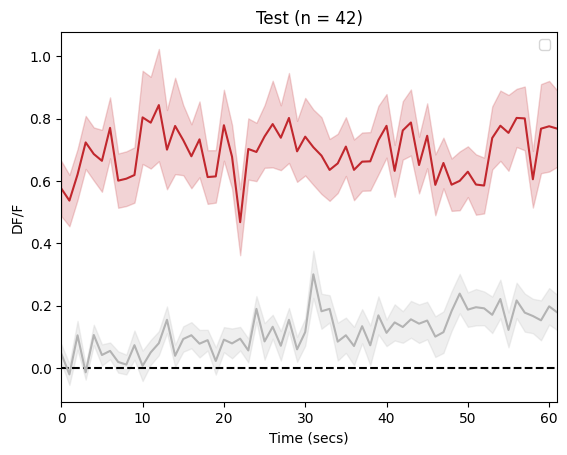

In [ ]:
"""
This is for comparing two areas of the dataframe at once. Change the t# values to set your windows of interest
can add more tha 4 ts if you want to compare more than 2 time periods
"""
t1 = stimulus_start + 5
t2 = stimulus_start + 67
t3 = stimulus_end - 62
t4 = stimulus_end

plt.plot([0,t2-t1],[0,0], 'k--')
plotme(mean_df[t1:t2], filepath, filename, Region, window_start, window_end, stimulus_start, stimulus_end, stimulus2_start, stimulus2_end, ybottom, ytop,
       color_num = 0)
plotme(mean_df[t3:t4], filepath, filename, Region, window_start, window_end, stimulus_start, stimulus_end, stimulus2_start, stimulus2_end, ybottom, ytop,
       color_num = 2)
plt.savefig(filepath + '/' + project + '/' + date + '/' +filename + ' Comparison graph.pdf')

# Stats

In [ ]:
"""
Stats

This portion of the code will look at the designated time points from each of the ROIs in the dataframe
and take the mean, max or median for the provided time points and put them in a new DataFrame
"""
p_threshold = 0.0
sns.despine()
t1 = 0
t2 = 0
t3 = 0
t4 = 0
t5 = 0
t6 = 0
t7 = 0
t8 = 0



if Single_Stimulus == 1:
  a = df[0:stimulus_start -1].mean(axis = 0)
  b = df[stimulus_start:early_stim_end].mean(axis = 0)
  c = df[late_stim_start:stimulus_end].mean(axis = 0)
  new_df = pd.concat([a,b,c], axis = 1)
  new_df.columns = ['Baseline','Early ' + Stimulus_Name, 'Late ' + Stimulus_Name]
elif Acquisition == 1:
  a = df[0:stimulus_start -1].mean(axis = 0)
  b = df[stimulus_start:early_stim_end].mean(axis = 0)
  c = df[late_stim_start:stimulus_end].mean(axis = 0)
  d = df[stimulus2_start:early_stim2_end].mean(axis = 0)
  e = df[late_stim2_start:stimulus2_end].mean(axis = 0)
  new_df = pd.concat([a,b,c,d,e], axis = 1)
  new_df.columns = ['Baseline','Early Odor 1', 'Late Odor 1',
                  'Early Odor 2 + Ethanol', 'Late Odor 2 + Ethanol']
elif Retrieval == 1:
  a = df[0:stimulus_start-1].mean(axis = 0)
  b = df[stimulus_start:early_stim_end].mean(axis = 0 )
  c = df[late_stim_start:stimulus_end].mean(axis = 0)
  d = df[stimulus2_start:early_stim2_end].mean(axis = 0)
  e = df[late_stim2_start:stimulus2_end].mean(axis = 0)
  new_df = pd.concat([a,b,c], axis = 1)
  new_df.columns = ['Baseline','Unpaired Odor','Paired Odor']

new_df = new_df.reset_index()

<Figure size 640x480 with 0 Axes>

In [ ]:
# @title Single Stimulus Stats Table

#now that the dataframe is formed, lets run stats!
stats_df = pd.DataFrame({})
shapiro_p_value = []
levene_p_value = []
anova_p_value = []
nemenyi_p_value = []
tukey_p_value = []
for column in new_df.iloc[:, 1:len(new_df)]:
    plt.figure()
    _, shap_value = shapiro(new_df[column])
    shapiro_p_value.append(shap_value)
    new_df[column].plot(kind='hist', density=True, edgecolor='black', title=f'Histogram for {column}')
    new_df[column].plot(kind='kde', title=f'Density Plot for {column} , p = ' + str(shap_value))
    print(f"Shapiro-Wilk test p-value for '{column}': {shap_value}")
    plt.show()
    plt.savefig(filepath + '/' +  project + '/' + date + '/' +filename + ' ' + str(column) + ' normality plot.pdf')
#Calculate p value for equivalence of distribution
lev_stat, lev_p = stats.levene(a,b,c)
levene_p_value.append(lev_p)
print('Your Levene p is ' + str(lev_p) + ' If it is less than 0.05 the variance between the two populations is very high and you should use non parametric test')



#Calculate p value and fstat for anova
if lev_p > p_threshold and min(shapiro_p_value) > p_threshold:
  f_stat, anova_p = f_oneway(new_df['Baseline'],new_df['Early ' + Stimulus_Name],new_df['Late '+ Stimulus_Name])
  anova_p_value.append(anova_p)
  if anova_p < p_threshold:
    combined_df = pd.concat([new_df['Baseline'],new_df['Early '+ Stimulus_Name],new_df['Late '+ Stimulus_Name]], ignore_index = True)
    tukey_results = pairwise_tukeyhsd(combined_df.melt())
    tukey_p_value.append(tukey_results)
  stats_table = {'Shapiro':shapiro_p_value,
                       'Levene':levene_p_value,
                       'Anova':anova_p_value,
                       'Tukey': tukey_p_value}

else:
  f_stat, anova_p = stats.friedmanchisquare(new_df['Baseline'],new_df['Early '+ Stimulus_Name],new_df['Late '+ Stimulus_Name])
  anova_p_value.append(anova_p)

  if anova_p < p_threshold:
    data = np.array([new_df['Baseline'], new_df['Early '+ Stimulus_Name], new_df['Late '+ Stimulus_Name]])
    nemenyi_p = sp.posthoc_nemenyi_friedman(data.T)
    print('your nemenyi_p stat is = ' + str(nemenyi_p))
  stats_table = {'Shapiro':shapiro_p_value,
                       'Levene':levene_p_value,
                       'Anova':anova_p_value,
                       'Nemenyi': nemenyi_p}
print('your f stat is = ' + str(f_stat), 'your anova p value is = ' + str(anova_p))


print(stats_table)

try:
    geeky_file = open(filepath + '/' + project + '/' + date + '/' +filename + ' stats.txt', 'wt')
    geeky_file.write(str(stats_table))
    geeky_file.close()

except:
    print("Unable to write to file")

In [ ]:
# @title Acquisition Stats Table
stats_df = pd.DataFrame({})
shapiro_p_value = []
levene_p_value = []
anova_p_value = []
nemenyi_p_value = []
tukey_p_value = []
for column in new_df.iloc[:, 1:len(new_df)]:
    plt.figure()
    _, shap_value = shapiro(new_df[column])
    shapiro_p_value.append(shap_value)
    new_df[column].plot(kind='hist', density=True, edgecolor='black', title=f'Histogram for {column}')
    new_df[column].plot(kind='kde', title=f'Density Plot for {column} , p = ' + str(shap_value))
    print(f"Shapiro-Wilk test p-value for '{column}': {shap_value}")
    plt.show()
    plt.savefig(filepath + '/' + project + '/' + date + '/' +filename + ' ' + str(column) + ' normality plot.pdf')
#Calculate p value for equivalence of distribution
lev_stat, lev_p = stats.levene(a,b,c)
levene_p_value.append(lev_p)
print('Your Levene p is ' + str(lev_p) + ' If it is less than 0.05 the variance between the two populations is very high and you should use non parametric test')



#Calculate p value and fstat for anova
if lev_p > p_threshold and min(shapiro_p_value) > p_threshold:
  f_stat, anova_p = f_oneway(new_df['Baseline'],new_df['Early Odor 1'],new_df['Late Odor 1'],
                             new_df['Early Odor 2 + Ethanol'],new_df['Late Odor 2 + Ethanol'])
  anova_p_value.append(anova_p)
  if anova_p < p_threshold:
    combined_df = pd.concat([new_df['Baseline'],new_df['Early Odor 1'],new_df['Late Odor 1'],
                            new_df['Early Odor 2 + Ethanol'], new_df['Late Odor 2 + Ethanol']], ignore_index = True)
    tukey_results = pairwise_tukeyhsd(combined_df.melt())
    tukey_p_value.append(tukey_results)
  stats_table = {'Shapiro':shapiro_p_value,
                       'Levene':levene_p_value,
                       'Anova':anova_p_value,
                       'Tukey': tukey_p_value}

else:
  f_stat, anova_p = stats.stats.friedmanchisquare(new_df['Baseline'],new_df['Early Odor 1'],new_df['Late Odor 1'],
                                        new_df['Early Odor 2 + Ethanol'], new_df['Late Odor 2 + Ethanol'])
  anova_p_value.append(anova_p)
  if anova_p < p_threshold:
    data = np.array([new_df['Baseline'], new_df['Early Odor 1'],
                     new_df['Late Odor 1'], new_df['Early Odor 2 + Ethanol'],
                      new_df['Late Odor 2 + Ethanol']])
    nemenyi_p = sp.posthoc_nemenyi_friedman(data.T)
    nemenyi_p_value.append(nemenyi_p)
    print('your nemenyi p stat is = ' + str(nemenyi_p_value))
  stats_table = {'Shapiro':shapiro_p_value,
                       'Levene':levene_p_value,
                       'Anova':anova_p_value,
                       'Nemenyi':nemenyi_p_value}
print('your f stat is = ' + str(f_stat), 'your anova p value is = ' + str(anova_p))






print(stats_table)

try:
    geeky_file = open(filepath + '/' + project + '/' + date + '/' +filename + ' stats.txt', 'wt')
    geeky_file.write(str(stats_table))
    geeky_file.close()

except:
    print("Unable to write to file")

In [ ]:
# @title Retrieval Stats Table
stats_df = pd.DataFrame({})
shapiro_p_value = []
levene_p_value = []
anova_p_value = []
nemenyi_p_value = []
tukey_p_value = []
for column in new_df.iloc[:, 1:len(new_df)]:
    plt.figure()
    _, shap_value = shapiro(new_df[column])
    shapiro_p_value.append(shap_value)
    new_df[column].plot(kind='hist', density=True, edgecolor='black', title=f'Histogram for {column}')
    new_df[column].plot(kind='kde', title=f'Density Plot for {column} , p = ' + str(shap_value))
    print(f"Shapiro-Wilk test p-value for '{column}': {shap_value}")
    plt.show()
    plt.savefig(filepath + '/' + project + '/' + date + '/' +filename + ' ' + str(column) + ' normality plot.pdf')
#Calculate p value for equivalence of distribution
lev_stat, lev_p = stats.levene(a,b,c)
levene_p_value.append(lev_p)
print('Your Levene p is ' + str(lev_p) + ' If it is less than 0.05 the variance between the two populations is very high and you should use non parametric test')



#Calculate p value and fstat for anova
if lev_p > p_threshold and min(shapiro_p_value) > p_threshold:
  f_stat, anova_p = f_oneway(new_df['Baseline'],new_df['Unpaired'],new_df['Paired'])
  anova_p_value.append(anova_p)
  if anova_p < p_threshold:
    combined_df = pd.concat([new_df['Baseline'],new_df['Unpaired'],new_df['Paired']], ignore_index = True)
    tukey_results = pairwise_tukeyhsd(combined_df.melt())
    tukey_p_value.append(tukey_results)
  stats_table = {'Shapiro':shapiro_p_value,
                       'Levene':levene_p_value,
                       'Anova':anova_p_value,
                       'Tukey': tukey_p_value}
else:
  print('Data is not normal, Friedman Chi Square Test is being used instead of Anova and Tukey')
  f_stat, anova_p = stats.friedmanchisquare(new_df['Baseline'],new_df['Unpaired'],new_df['Paired'] )
  anova_p_value.append(anova_p)
  if anova_p < p_threshold:
    data = np.array([new_df['Baseline'], new_df['Unpaired'], new_df['Paired']])
    nemenyi_p = sp.posthoc_nemenyi_friedman(data.T)
    nemenyi_p_value.append(nemenyi_p)
    print('your nemenyi_p stat is = ' + str(nemenyi_p))
  stats_table = {'Shapiro':shapiro_p_value,
                       'Levene':levene_p_value,
                       'Anova':anova_p_value,
                       'Nemenyi': nemenyi_p}
print('your f stat is = ' + str(f_stat), 'your anova p value is = ' + str(anova_p))






print(stats_table)

try:
    geeky_file = open(filepath + '/' + project + '/' + date + '/' +filename + ' stats.txt', 'wt')
    geeky_file.write(str(stats_table))
    geeky_file.close()

except:
    print("Unable to write to file")

# Violin Plots

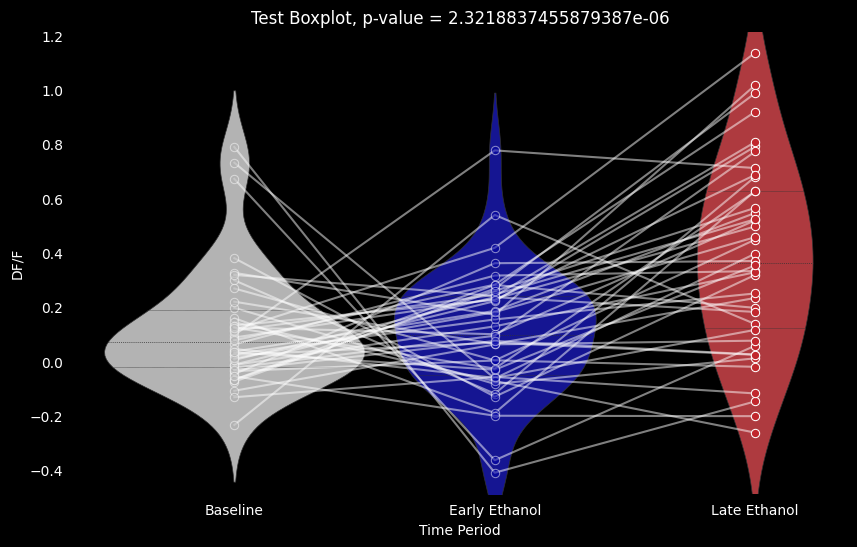

In [ ]:
# @title Single Stimulus
"""
This code chunk is for generating violin/boxplots for etoh only
"""
#df.plot()
fig, ax = plt.subplots(figsize=(10, 6))
plt.setp(ax.collections, alpha=0.4)
## if want black
fig.patch.set_facecolor('black')  # Set the background color of the figure
ax.set_facecolor('black')          # Set the background color of the axis
ax.tick_params(axis='both', colors='white')


ax = sns.violinplot(data = new_df, width = 1, palette = custom_palette, linewidth = 0.5, inner = 'quart', gap = 0)
"""
use swarmplot for just adding randomly spaced individual dots
use sns.lineplot for rigidly structured and connected dots across time periods
"""
# ax = sns.swarmplot(data = new_df, palette = custom_palette,
#               color="0.1", alpha = 0.5, size = 5,
#               linewidth = 2)
## Do this if you want to add individual dots with lines connecting them
counter = 1
for n in df.columns[1:]:
  sns.lineplot(y = [new_df['Baseline'][counter], new_df['Early ' +Stimulus_Name][counter], new_df['Late ' + Stimulus_Name][counter]],
               x = ['Baseline', 'Early ' + Stimulus_Name, 'Late ' +Stimulus_Name], alpha = 0.5, color = 'w')
  sns.lineplot(y = [new_df['Baseline'][counter]],
               x = ['Baseline'], alpha = 0.5, marker = 'o', color = custom_palette[0])
  sns.lineplot(y = [new_df['Early ' +Stimulus_Name][counter]],
               x = ['Early ' + Stimulus_Name], alpha = 0.5, marker = 'o', color = custom_palette[1])
  sns.lineplot(y = [new_df['Late ' +Stimulus_Name][counter]],
               x = ['Late ' +Stimulus_Name], alpha = 1, marker = 'o', color = custom_palette[2])
  counter = counter + 1



sns.despine(left=True, bottom = True)
plt.tick_params(left = False, bottom = False)

#plt.figure(figsize=(10, 6))
plt.title(filename + ' Boxplot' + ', p-value = ' +str(anova_p), color = 'w')
plt.xlabel("Time Period", color = 'w')
plt.ylabel("DF/F", color = 'w')
#plt.ylim((-0.2,0.75))



#plt.show()
plt.savefig(filepath + '/'+ project +  '/' + date +'/' +filename + ' violinplot.pdf')

In [ ]:
# @title Acquisition of Alcohol Memory
"""
This code chunk is for generating violin/boxplots for acquisition
"""

fig, ax = plt.subplots(figsize=(10, 6))
plt.setp(ax.collections, alpha=0.4)
## if want black
fig.patch.set_facecolor('black')  # Set the background color of the figure
ax.set_facecolor('black')          # Set the background color of the axis
ax.tick_params(axis='both', colors='white')


ax = sns.violinplot(data = new_df, width = 1, palette = custom_palette2, linewidth = 0.5, inner = 'quart', gap = 0)
"""
use swarmplot for just adding randomly spaced individual dots
use sns.lineplot for rigidly structured and connected dots across time periods
"""
# ax = sns.swarmplot(data = new_df, palette = custom_palette2,
#               color="0.1", alpha = 0.5, size = 5,
#               linewidth = 2)
## Do this if you want to add individual dots with lines connecting them
counter = 1
for n in df.columns[1:]:
  sns.lineplot(y = [new_df['Baseline'][counter], new_df['Early Odor 1'][counter], new_df['Late Odor 1'][counter],
               new_df['Early Odor 2 + Ethanol'][counter], new_df['Late Odor 2 + Ethanol'][counter]],
               x = ['Baseline', 'Early Odor 1', 'Late Odor 1', 'Early Odor 2 + Ethanol', 'Late Odor 2 + Ethanol'], alpha = 0.5, color = 'w')
  sns.lineplot(y = [new_df['Baseline'][counter]],
               x = ['Baseline'], alpha = 0.5, marker = 'o', color = custom_palette2[0])
  sns.lineplot(y = [new_df['Early Odor 1'][counter]],
               x = ['Early Odor 1'], alpha = 0.5, marker = 'o', color = custom_palette2[1])
  sns.lineplot(y = [new_df['Late Odor 1'][counter]],
               x = ['Late Odor 1'], alpha = 1, marker = 'o', color = custom_palette2[2])
  sns.lineplot(y = [new_df['Early Odor 2 + Ethanol'][counter]],
               x = ['Early Odor 2 + Ethanol'], alpha = 1, marker = 'o', color = custom_palette2[3])
  sns.lineplot(y = [new_df['Late Odor 2 + Ethanol'][counter]],
               x = ['Late Odor 2 + Ethanol'], alpha = 1, marker = 'o', color = custom_palette2[4])
  counter = counter + 1


sns.despine(left=True, bottom = True)
plt.tick_params(left = False, bottom = False)

#plt.figure(figsize=(10, 6))
plt.title(filename + ' Boxplot' + ', Kruskal-Wallis p-value = ' +str(anova_p), color = 'w')
plt.xlabel("Time Period", color = 'w')
plt.ylabel("DF/F", color = 'w')
plt.ylim((-0.4,1.2))



#plt.show()
plt.savefig(filepath + '/' +filename + ' violinplot.pdf')

In [ ]:
# @title Retrieval Violin Plots
"""
This code chunk is for generating violin/boxplots for Retrieval
"""

fig, ax = plt.subplots(figsize=(10, 6))
plt.setp(ax.collections, alpha=0.4)
## if want black
fig.patch.set_facecolor('black')  # Set the background color of the figure
ax.set_facecolor('black')          # Set the background color of the axis
ax.tick_params(axis='both', colors='white')


ax = sns.violinplot(data = new_df, width = 1, palette = custom_palette2, linewidth = 0.5, inner = 'quart', gap = 0)
"""
use swarmplot for just adding randomly spaced individual dots
use sns.lineplot for rigidly structured and connected dots across time periods
"""
# ax = sns.swarmplot(data = new_df, palette = custom_palette2,
#               color="0.1", alpha = 0.5, size = 5,
#               linewidth = 2)
## Do this if you want to add individual dots with lines connecting them
counter = 1
for n in df.columns[1:]:
  sns.lineplot(y = [new_df['Baseline'][counter], new_df['Unpaired'][counter], new_df['Paired'][counter]],
               x = ['Baseline', 'Unpaired', 'Paired'], alpha = 0.5, color = 'w')
  sns.lineplot(y = [new_df['Baseline'][counter]],
               x = ['Baseline'], alpha = 0.5, marker = 'o', color = custom_palette2[0])
  sns.lineplot(y = [new_df['Unpaired'][counter]],
               x = ['Unpaired'], alpha = 0.5, marker = 'o', color = custom_palette2[7])
  sns.lineplot(y = [new_df['Paired'][counter]],
               x = ['Paired'], alpha = 1, marker = 'o', color = custom_palette2[2])
  counter = counter + 1


sns.despine(left=True, bottom = True)
plt.tick_params(left = False, bottom = False)

#plt.figure(figsize=(10, 6))
plt.title(filename + ' Boxplot' + ', Kruskal-Wallis p-value = ' +str(anova_p), color = 'w')
plt.xlabel("Time Period", color = 'w')
plt.ylabel("DF/F", color = 'w')
plt.ylim((-0.2,0.75))



#plt.show()
plt.savefig(filepath + '/' +filename + ' violinplot.pdf')

# Fancy Stuff

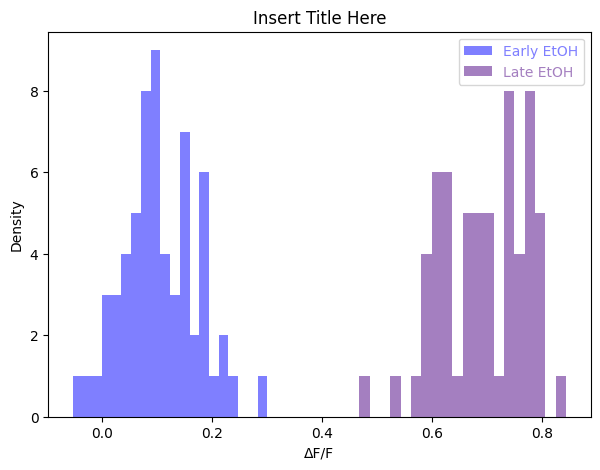

In [ ]:
# @title Frequency Plots
"""
Creates a histogram comparing two time periods that you designate
times should be in seconds
"""
 # this is just to set up the graph
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)
title = 'Test'
fig.patch.set_facecolor('white') #or black

t1 = stimulus_start
t2 = stimulus_start + 62
t3 = stimulus_end - 62
t4 = stimulus_end
t5 = 0
t6 = 0
t7 = 0
t8 = 0


"""
could add multiple x's to increase number of things you want to plot
"""
# def counts_histogram(df, filepath, title, t1 = None, t2 = None, t3 = None
#                      t4 = None, t5 = None, t6 = None)

x = mean_df[Region + ' Average'].iloc[t1:t2]
x2 = mean_df[Region + ' Average'].iloc[t3:t4]
#x3 = df[roi + 'Average'].iloc[t5:t6]
fig = plt.figure()
#fig.spines[['right', 'top']].set_visible(False)
plt.hist(x, bins=20, alpha = 0.5, label = 'Early EtOH', color = 'blue')
plt.hist(x2, bins=20, alpha = 0.5, label = 'Late EtOH', color = 'indigo')
plt.legend(labelcolor = 'linecolor')
plt.rcParams['axes.facecolor'] = 'w' #or black or white
plt.title('Insert Title Here', color = 'k')
plt.gca().set(xlabel = '\u0394F/F' ,ylabel='Density');
plt.savefig(filepath + '/' + project + '/' + date + '/' + title+ ' Frequency graph.pdf')

In [ ]:
# @title Time Series Gifs
"""
Work in progress, was working until fill between stopped the code from working.
"""

# Function to update the plot for each frame

sem_values = mean_df[Region + ' SEM']
def update(frame):
    plt.clf()  # Clear previous plot
    plt.plot(mean_df['Frame'][:frame + 1], mean_df[Region + ' Average'][:frame + 1], color = 'k')
    plt.fill_between(mean_df['Frame'][:frame + 1],
                     mean_df[Region + ' Average'][:frame + 1] - sem_values,
                     mean_df[Region + ' Average'][:frame + 1] + sem_values,
                     color='gray', alpha=0.3, label='SEM')
    plt.title(f'Time: {frame}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('DF/F')

# Create the animation
animation = FuncAnimation(plt.gcf(), update, frames=len(df), interval=window_end, repeat=False)

# Save the animation as a GIF (optional)
animation.save(filepath + '/' + filename +  ' Mean.gif', writer='pillow')

# Display the animation
HTML(animation.to_jshtml())

#takes 6 minutes

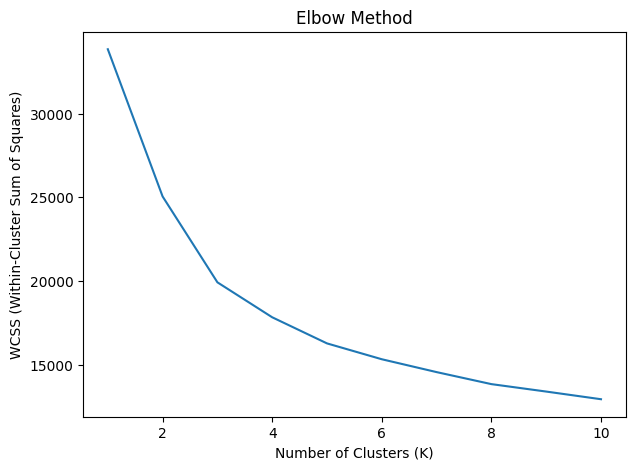

Cluster Assignments: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 4 4 4 1 1 1 4 4 4 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 2 2 2 4 2 4 2 2 2 2 4 2 2 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2
 3 2 0 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 0 2 0 2 0 2 0 2 0 0 2 2 2 2 2 2 2 0 2 2 0 0 2 2 2 2 0 0 2
 2 2 0 2 2 0 2 0 2 0 2 2 2 2 2 2 0 2 0 2 2 2 2 2 0 0 0 2 0 0 2 0 2 2 2 2 3
 0 2

In [ ]:
# @title K-means clustering of cells
# Load your single-cell activity traces data (replace this with your data)
# For example, if your data is in a CSV file:
# data = np.genfromtxt('your_data.csv', delimiter=',')

# Sample data (replace this with your actual data)


# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

# Determine the optimal number of clusters (K) using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(normalized_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Choose the optimal K and perform K-means clustering
optimal_k = 5  # replace this with the optimal K from the elbow method
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(normalized_data)

# Now 'clusters' contains the cluster assignments for each cell
print("Cluster Assignments:", clusters)

/usr/local/lib/python3.10/dist-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
<ipython-input-146-39492e698bbb>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('terrain', Ks)


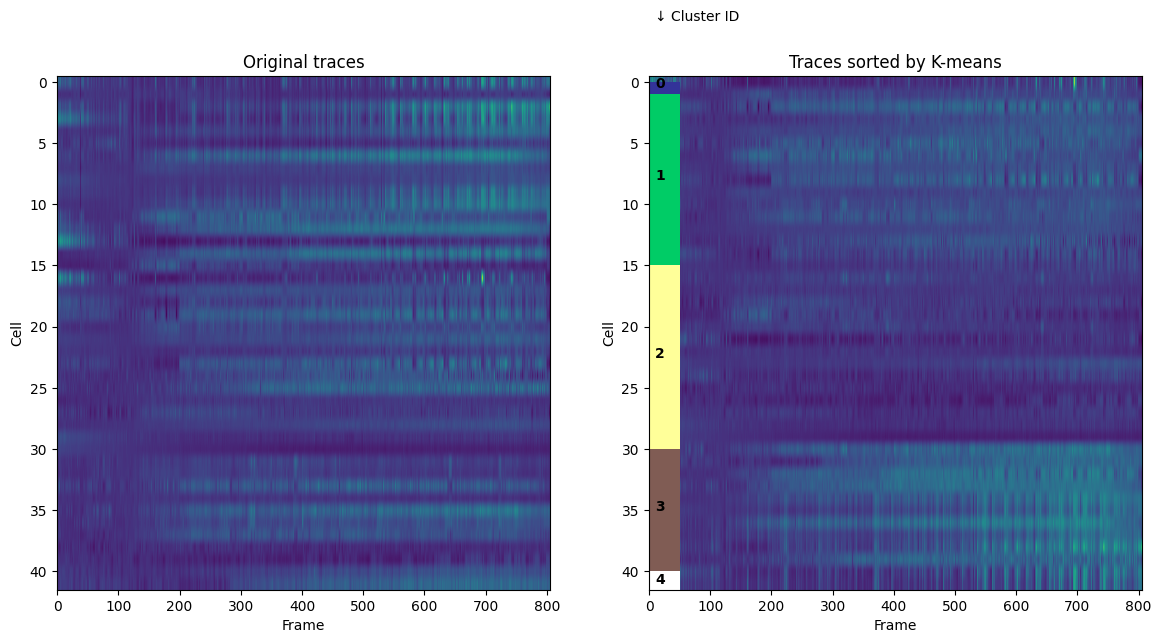

In [ ]:
"""
plots heatmap both unclustered and clustered
"""
data_t = np.asarray(df.iloc[:,:].T);
plt.figure(figsize=(14,14))
ax1 = plt.subplot(1,2,1)
plt.imshow(data_t)
ax1.set_aspect(20)
plt.title('Original traces');

ax2 = plt.subplot(1,2,2)

Ks = 5
# K-means relies on random number generation, we can fix the seed to have same result each time
centroid, labels = kmeans2(data_t, Ks, seed=1111111)

# argsort outputs indeces after sorting the argument
# so i_labels contains indeces of cells, sorted by corresponding cluster ID
i_labels = np.argsort(labels)

plt.imshow(data_t[i_labels,:])
ax2.set_aspect(20)
plt.title('Traces sorted by K-means');

cmap = cm.get_cmap('terrain', Ks)

# Cosmetic code to create a Rectangle patches to label specific K-cluster
Koffset = 0
for Ki in range(Ks):
    Nk = np.size(np.where(labels == Ki))
    # 40 is width of the rectangle
    rect = patches.Rectangle((0, Koffset), 50, Nk, linewidth=1, edgecolor='none', facecolor=cmap(Ki))
    ax2.text( 10, Koffset + Nk/2, Ki ,color='k', weight='bold')
    # Add the patch to the plot
    ax2.add_patch(rect)
    Koffset += Nk

ax2.text(10,-5,'↓ Cluster ID',fontsize=10)


# add subplot labels
# ax1.text(-200,-10,'A',fontsize=15)
# ax2.text(-200,-10,'B',fontsize=15)

ax1.set_xlabel('Frame')
ax2.set_xlabel('Frame')

ax1.set_ylabel('Cell')
ax2.set_ylabel('Cell')

plt.show()

<ipython-input-84-97584a3ffae5>:297: RuntimeWarning: invalid value encountered in double_scalars
  return (f - np.min(f))/np.max(f - np.min(f))


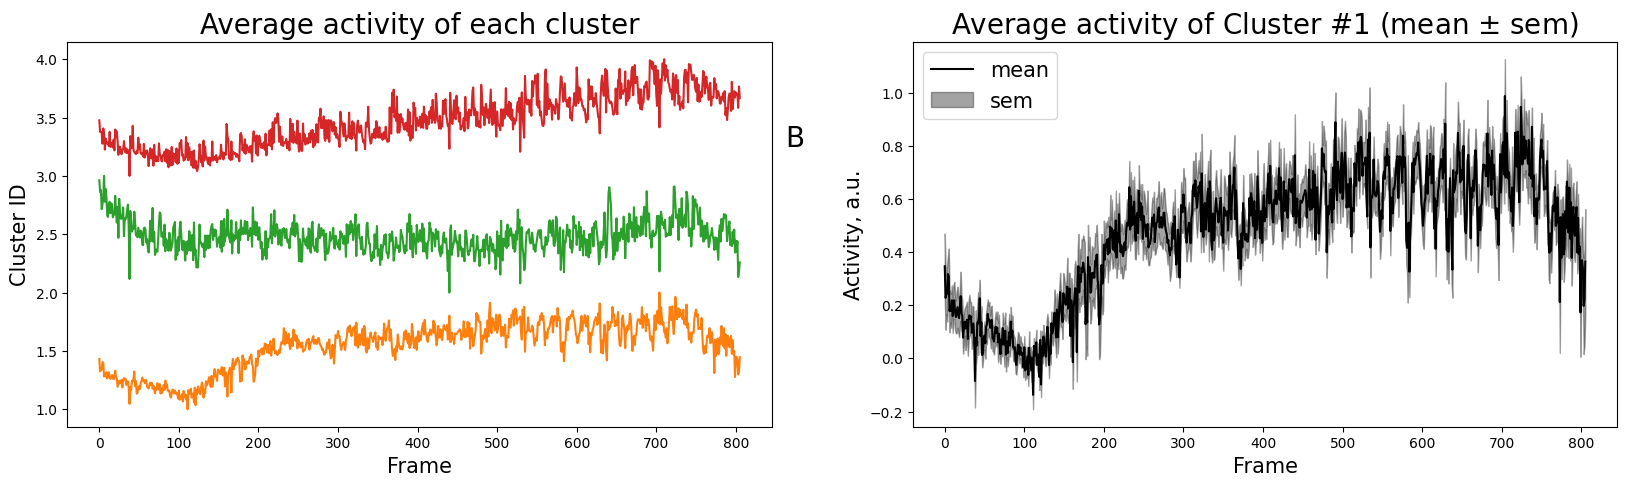

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.subplot(121)
for Ki in range(0,Ks):
    # find indeces of traces where cluster label equals to Ki
    js = np.where(labels == Ki);
    # calculate average activity trace for cluster Ki
    d  = np.mean(np.squeeze(data_t[js, :]), axis=0);
    # normalize so that each trace is between 0 and 1
    d  = norm(d);
    plt.plot(d+Ki)

p = plt.gca();
p.set_ylabel('Cluster ID', fontsize=15)
p.set_xlabel('Frame', fontsize=15)
p.set_title('Average activity of each cluster', fontsize=20)

# add subplot label for figure
#plt.text(-200,6.5,'A',fontsize=20)


plt.subplot(122)

K0 = 1;
iis = np.where(labels == K0)[0];
m = np.mean(data_t[iis,:], 0)
s = stats.sem(data_t[iis,:], 0)
ts = range(0,window_end)
plt.plot(m,'-k')
# create fill between mean-std and mean+std, fill with grey color
plt.fill_between(ts, m-s, m+s, alpha=0.4, color=(0.1,0.1,0.1))
p = plt.gca();

# Here we use LaTeX symbol for plus/minus sign
p.set_title('Average Activity of Cluster #' +str(K0)+  ' (mean $\pm$ sem)', fontsize=20)
p.set_xlabel('Frame', fontsize=15)
p.set_ylabel('Activity, a.u.', fontsize=15)

p.legend(('Mean','SEM'), fontsize=15)
plt.text(-200,0.8,'B',fontsize=20)
plt.show();

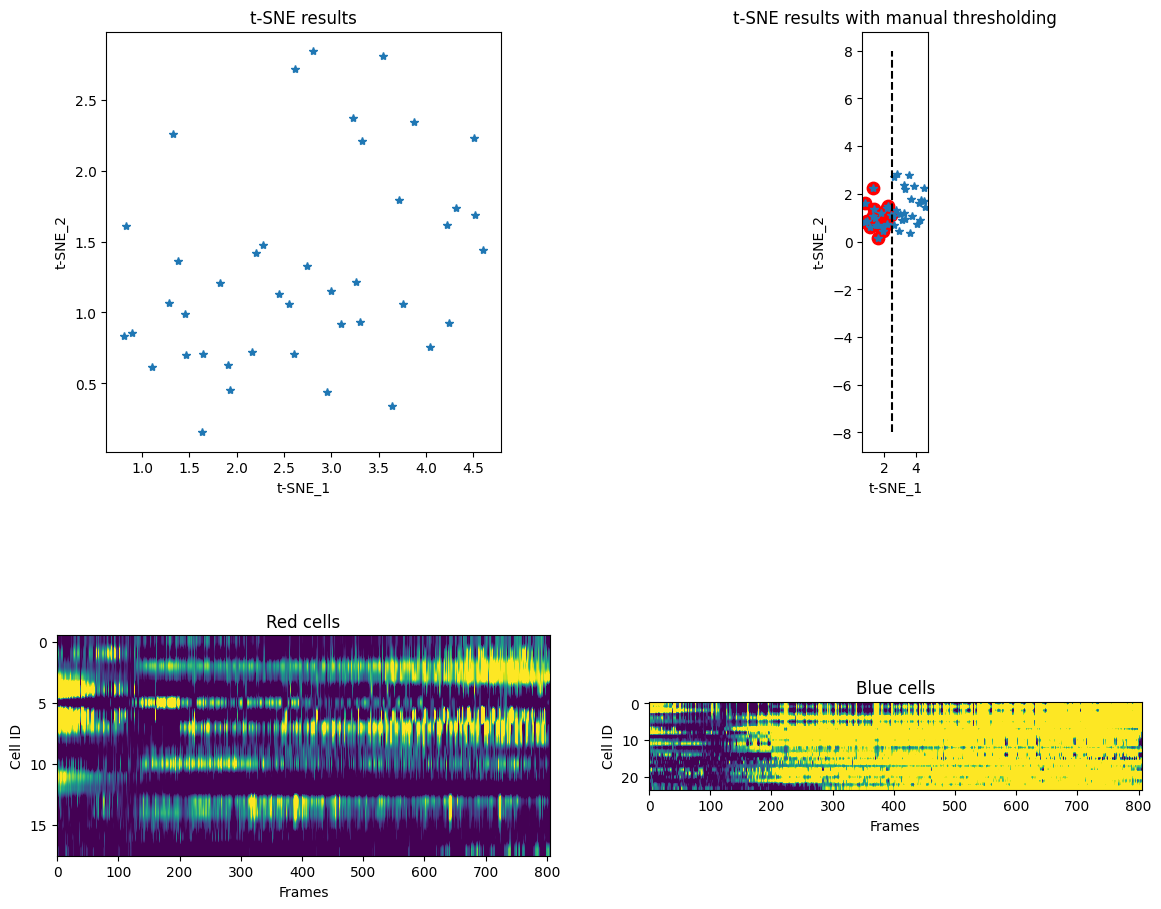

In [ ]:
# perform t-SNE dimentionality reduction
# t-SNE relies or random number generation, so we fix random_state to have same result each time we run the code
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1113).fit_transform(data_t)
plt.figure(figsize=(14,12))

# plot t-SNE embedding in two-dimentional space
ax_tsne = plt.subplot(221)
plt.plot(X_embedded[:,0], X_embedded[:,1],'*')
#plt.text(-20,9,'A',fontsize=20)

# format aspect ratio and axis labels
ax_tsne.set_aspect(1.5)
ax_tsne.set_xlabel('t-SNE_1')
ax_tsne.set_ylabel('t-SNE_2')
ax_tsne.set_title('t-SNE results')

# repeat plotting for further manual thresholding
ax_tsne = plt.subplot(222)
plt.plot(X_embedded[:,0], X_embedded[:,1],'*')
ax_tsne.set_aspect(1.5)
ax_tsne.set_xlabel('t-SNE_1')
ax_tsne.set_ylabel('t-SNE_2')
ax_tsne.set_title('t-SNE results with manual thresholding')
#plt.xlim(-5, 5)
#plt.text(-20,9,'B',fontsize=20)


# manually split all elements by tSNE_1 = 2.5
# np.where returns index of elements that satisfy given condition
#can isolate cells using the threshold
threshold = 2.5
iis_red = np.where(X_embedded[:,0]<threshold);
iis_blue = np.where(X_embedded[:,0]>=threshold);

# label points left to the tSNE_1 = -5 line in red
plt.scatter(X_embedded[iis_red,0], X_embedded[iis_red,1],80, 'r', marker='o')
# demarcation line
plt.plot([threshold, threshold],[-8, 8],'--k')

# plot traces of all "red" cells
ax1 = plt.subplot(223)
plt.imshow(data_t[np.asarray(iis_red)[0],:], vmin=0,vmax=.50)
ax1.set_aspect(20)
ax1.set_title('Red cells')
ax1.set_ylabel('Cell ID')
ax1.set_xlabel('Frames')
#plt.text(-200,-2,'C',fontsize=20)

# plot traces of all "non-red" cells
ax2 = plt.subplot(224)
plt.imshow(data_t[np.asarray(iis_blue)[0],:], vmin=0,vmax=.50)
ax2.set_aspect(6)
ax2.set_title('Blue cells')
ax2.set_ylabel('Cell ID')
ax2.set_xlabel('Frames')
#plt.text(-200,-2,'D',fontsize=20)

plt.show()

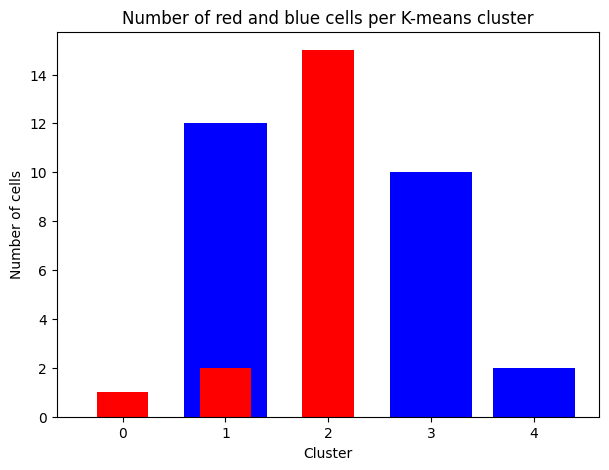

In [ ]:
# Compare manual segmentation into red/blue cells and K-means clustering from earlier step
# Plot historgram of cluster values for red cenns and blue cells
plt.hist(labels[iis_blue], bins=range(Ks+1),align='left',rwidth=0.8,facecolor='b')
plt.hist(labels[iis_red],  bins=range(Ks+1),align='left',rwidth=0.5,facecolor='r')
# Red cells are exclusively present in clusters 0 and 3

ax = plt.gca()
ax.set_title('Number of red and blue cells per K-means cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of cells')

plt.show()

# Extraneous Stuff

In [ ]:
# @title toy dataframe
frame_column = np.arange(0, 1200)

# Generate random values for the other 10 columns
data_values = np.random.uniform(0.01, 4.0, size=(1200, 100))

# Create the dataframe
df = pd.DataFrame(data_values, columns=[f'Column_{i}' for i in range(1, 101)])

# Insert the 'Frame' column at the beginning
df.insert(0, 'Frame', frame_column)

# Display the dataframe
print(df)

In [ ]:
# @title Power Analysis
import scipy.stats as stats
import numpy as np

# Set the parameters for the power analysis
effect_size = 0.15  # Anticipated effect size
alpha = 0.01      # Significance level
power_value = 0.8 # Desired power
sigma = 0.15       # Population standard deviation
alternative = 'larger'  # 'two-sided', 'larger', or 'smaller'

# Calculate the Z score for the desired power (1 - alpha)
z_power = stats.norm.ppf(1 - alpha)

# Calculate the standard error (SE) using the population standard deviation (sigma)


# Calculate the required sample size using the formula: n = ((z_power + stats.norm.ppf(1 - power_value)) * sigma / effect_size) ** 2
n = ((z_power + stats.norm.ppf(1 - power_value)) * sigma / effect_size) ** 2
se = sigma / np.sqrt(n)
print(f"Sample size required: {round(n)}")

In [ ]:
# @title Time Converter
"""
Converter is a function that I use to convert between the frames read out from the scientifica scope (e.g. 1860 frames), and the number of seconds or minutes in actual time.
This is necssary because the scientifica scope records at 30.9 fps(31 FPS). When we convert the RAW files to tifs, we need to have them be a multiple of 31 or 30 in order
to generate a hyperstack in fiji. You can either feed in number of frames to get the number of seconds/mins, or can feed it seconds to get the number of mins/frames, and same for mins.


numframes: a float that represents the number of frames
nummins = a float that represents the number of seconds
numsecs = a float that represents the number of seconds you want to convert
"""
def converter(numframes=False, nummins=False, numsecs=False):
    conversion = {"Number of Frames":[], "Number of Minutes":[], 'Number of Seconds':[]}
    if type(numframes) == int or type(numframes) == float:
        conversion['Number of Frames'].append(numframes)
        mins = numframes/(FPS*Secs_in_Min)
        conversion['Number of Minutes'].append(mins)
        secs = numframes/FPS
        conversion['Number of Seconds'].append(secs)
    elif type(nummins) == int or type (nummins) == float:
        conversion['Number of Minutes'].append(nummins)
        frames = nummins *FPS*Secs_in_Min
        conversion['Number of Frames'].append(frames)
        secs = nummins *Secs_in_Min
        conversion['Number of Seconds'].append(secs)
    elif type(numsecs) == int or type(numsecs) == float:
        conversion['Number of Seconds'].append(numsecs)
        mins = numsecs/Secs_in_Min
        conversion['Number of Minutes'].append(mins)
        frames = numsecs*FPS
        conversion['Number of Frames'].append(frames)
    else:
        print('you are in the wrong place at the wrong time >:]')

    return conversion
#dont feel like doing the math, here is the easy way to get the desired time measure you want
a = converter(numframes = 3720)
print(a)
b = converter(numsecs = 806)
print(b)
c = converter(nummins =11)
print(c)
# 62 seconds per cycle